In [127]:
%load_ext autoreload
%autoreload 2
%cd ~/Research/Sriram/DeepSetRNN

import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import os
import string
import pickle
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import logging
import os
import importlib

from src import convert_dot_format
from src import experiment_utils

DATA_PATH='data/MIMIC3database'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/minh/Research/Sriram/DeepSetRNN


In [2]:
logging.info("starting logger")
_LOGGER = logging.getLogger('MIMIC_BOW_input_models')
_LOGGER.setLevel(logging.DEBUG)

# Preprocessing Data

In [ ]:
# reading in data 

In [3]:
top_n = 100 #should be the same as before
diagnoses_procedures_df = pd.read_csv('data/MIMIC3database/processed/ICD9_diagnoses_procedures_mimic_idx_sentences_top_100_sorted.csv', index_col=0)

#converting sentences to a single column
diagnoses_procedures_df['DIAGNOSES_SENTENCES'] = diagnoses_procedures_df[['0_diagnoses', '1_diagnoses',
       '2_diagnoses', '3_diagnoses', '4_diagnoses', '5_diagnoses',
       '6_diagnoses', '7_diagnoses', '8_diagnoses', '9_diagnoses',
       '10_diagnoses', '11_diagnoses', '12_diagnoses', '13_diagnoses',
       '14_diagnoses', '15_diagnoses', '16_diagnoses', '17_diagnoses',
       '18_diagnoses', '19_diagnoses', '20_diagnoses', '21_diagnoses', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31']].values.tolist()

diagnoses_procedures_df['PROCEDURES_SENTENCES'] = diagnoses_procedures_df[
    ['0_procedures', '1_procedures', '2_procedures', '3_procedures',
       '4_procedures', '5_procedures', '6_procedures', '7_procedures',
       '8_procedures', '9_procedures', '10_procedures', '11_procedures',
       '12_procedures', '13_procedures', '14_procedures', '15_procedures',
       '16_procedures', '17_procedures', '18_procedures', '19_procedures',
       '20_procedures', '21_procedures']].values.tolist()

diagnoses_procedures_df.drop(labels=['0_diagnoses', '1_diagnoses',
       '2_diagnoses', '3_diagnoses', '4_diagnoses', '5_diagnoses',
       '6_diagnoses', '7_diagnoses', '8_diagnoses', '9_diagnoses',
       '10_diagnoses', '11_diagnoses', '12_diagnoses', '13_diagnoses',
       '14_diagnoses', '15_diagnoses', '16_diagnoses', '17_diagnoses',
       '18_diagnoses', '19_diagnoses', '20_diagnoses', '21_diagnoses', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31'], axis=1, inplace=True)

diagnoses_procedures_df.drop(labels=['0_procedures', '1_procedures', '2_procedures', '3_procedures',
       '4_procedures', '5_procedures', '6_procedures', '7_procedures',
       '8_procedures', '9_procedures', '10_procedures', '11_procedures',
       '12_procedures', '13_procedures', '14_procedures', '15_procedures',
       '16_procedures', '17_procedures', '18_procedures', '19_procedures',
       '20_procedures', '21_procedures'], axis=1, inplace=True)

diagnoses_procedures_df.to_csv("data/MIMIC3database/processed/ICD9_diagnoses_procedures_mimic_idx_sentences_top_100_sorted_concat.csv")

In [ ]:
# generating the labels with 1 hot encoding

In [40]:
from src.utils import get_onehot_vector

diagnoses_counts = diagnoses_procedures_df['ICD9_CODE_diagnoses'].value_counts()
procedures_counts = diagnoses_procedures_df['ICD9_CODE_procedures'].value_counts()

diagnoses_set = set(diagnoses_counts.keys()[:top_n])
procedures_set = set(procedures_counts.keys()[:top_n])

diagnoses_idx_map = {}
for i, code in enumerate(diagnoses_counts.keys()[:top_n]):
    diagnoses_idx_map[code] = i

procedures_idx_map = {}
for i, code in enumerate(procedures_counts.keys()[:top_n]):
    procedures_idx_map[code] = i
    
data = list(diagnoses_procedures_df.groupby(['SUBJECT_ID']))
data = [(subject_id, list(subject_data.groupby(['HADM_ID', 'ADMITTIME']))) for subject_id, subject_data in data]

all_inputs = []
all_outputs = []
for _, subject in data:
    input_series = []
    output_series = []
    for _, timestep in subject:
        timestep = timestep[timestep['ICD9_CODE_diagnoses'].isin(diagnoses_set)
                           | timestep['ICD9_CODE_procedures'].isin(procedures_set)]
        
        diagnoses_one_hot = get_onehot_vector(timestep['ICD9_CODE_diagnoses'], diagnoses_idx_map)
        procedures_one_hot = get_onehot_vector(timestep['ICD9_CODE_procedures'], procedures_idx_map)
            #skipping timesteps that are not relevant
        if len(timestep) > 0:
            input_series.append((np.append(diagnoses_one_hot, procedures_one_hot)))
            output_series.append(diagnoses_one_hot)
    if len(input_series) > 0 and len(output_series):
        all_inputs.append(torch.tensor(input_series))
        all_outputs.append(torch.tensor(output_series))
        
all_inputs = list(map(lambda x : x.type(torch.FloatTensor), all_inputs))
all_outputs = list(map(lambda x : x.type(torch.FloatTensor), all_outputs))

In [ ]:
#only retaining individuals with at lesat 3 visits

In [41]:
min_len = 3

inputs = list(filter(lambda x : len(x) >= min_len, all_inputs))
outputs = list(filter(lambda x: len(x) >= min_len, all_outputs))

n_seq = len(inputs)

split = int(n_seq*0.8)
train_inputs = inputs[:split]
train_outputs =  outputs[:split]

test_inputs = inputs[split:n_seq]
test_outputs = outputs[split:n_seq]

# Training Models

In [ ]:
#global map to store training loss and models

In [135]:
#global objects
training_loss_map = {}
model_map = {}

In [ ]:
#model and log paths

In [124]:
_MODEL_LOG_ROOT_PATH = 'logs/MIMIC3/bow'
_MODEL_ROOT_PATH = 'models/MIMIC3/bow'

In [ ]:
#helper function that uses files from src/experimental_utils.py to train a model given optimizer, save the model, and report validation loss

In [125]:
def run_train_and_log_experiments(model_name, model, loss_fn, optimizer):
    experiment_utils.setup_model_logger(_LOGGER, model_name, _MODEL_LOG_ROOT_PATH)
    _LOGGER.info(model_name)

    #initial test loss
    test_losses = experiment_utils.evaluate_validation_loss(model, loss_fn, test_inputs, test_outputs)
    _LOGGER.info("Initial Validation Loss: {}".format(np.mean(test_losses)))

    #training model
    training_losses = experiment_utils.train_model(model, loss_fn, optimizer,
                                                  args.n_epoch, train_inputs, 
                                                   train_outputs, _LOGGER)

    #saving model
    torch.save(model, '{}/{}.pt'.format(_MODEL_ROOT_PATH, model_name))

    #final validation loss
    test_losses = experiment_utils.evaluate_validation_loss(model, loss_fn, test_inputs, test_outputs)
    _LOGGER.info("final validation Loss: {}".format(np.mean(test_losses)))

    #saving model in global map
    model_map[model_name] = model
    training_loss_map[model_name] = training_losses

In [ ]:
# the strucutre of the code is defining hyperparameters with a named tuple
# creating a model object
# ddefining loss
# defining optimizer
# running the helper function above

In [159]:
######LSTM MODEL#####
from src.model.mimic_onehot import OneHotLSTMClassifier

LSTMArgs = namedtuple('BOW_LSTM', 
                      ['hidden_dim',
                       'n_epoch',
                       'lr',
                       'momentum',
                      'n_layers',
                      'dropout'])
args = LSTMArgs(
    hidden_dim=[1000,100],
    n_epoch = 10,
    lr = 0.1,
    n_layers=1,
    momentum = 0.9,
    dropout = 0.2
)

model_name = str(args)

model = OneHotLSTMClassifier(
    input_dim=len(inputs[0][0]),
    hidden_dims=args.hidden_dim,
    n_layers=args.n_layers,
    n_class=top_n)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
run_train_and_log_experiments(model_name, model, loss_fn, optimizer)

INFO:MIMIC_BOW_input_models:BOW_LSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.2)
INFO:MIMIC_BOW_input_models:Initial Validation Loss: 0.697964072227478
DEBUG:MIMIC_BOW_input_models:training model
INFO:MIMIC_BOW_input_models:epoch: 0, loss: 0.2437218576669693
INFO:MIMIC_BOW_input_models:epoch: 1, loss: 0.20545515418052673
INFO:MIMIC_BOW_input_models:epoch: 2, loss: 0.18554668128490448
INFO:MIMIC_BOW_input_models:epoch: 3, loss: 0.1698475033044815
INFO:MIMIC_BOW_input_models:epoch: 4, loss: 0.1577046662569046
INFO:MIMIC_BOW_input_models:epoch: 5, loss: 0.14733371138572693
INFO:MIMIC_BOW_input_models:epoch: 6, loss: 0.13844093680381775
INFO:MIMIC_BOW_input_models:epoch: 7, loss: 0.1315547227859497
INFO:MIMIC_BOW_input_models:epoch: 8, loss: 0.12522463500499725
INFO:MIMIC_BOW_input_models:epoch: 9, loss: 0.11957152187824249
INFO:MIMIC_BOW_input_models:final validation Loss: 0.2732766568660736


In [ ]:
#FCN model

In [136]:
######FCN MODEL#####
from src.model.mimic_onehot import OneHotFullyConnectedClassifier

FCArgs = namedtuple('BOW_FCN', 
                      ['hidden_dim',
                       'n_epoch',
                       'lr',
                       'momentum'])
args = FCArgs(
    hidden_dim=[1000,100],
    n_epoch = 10,
    lr = 0.1,
    momentum = 0.9
)


_LOGGER.handlers = [
    h for h in _LOGGER.handlers if not isinstance(h, logging.StreamHandler)]
model_name = str(args)
fh = logging.FileHandler('logs/MIMIC3/onehot/{}.log'.format(model_name))
fh.setLevel(logging.DEBUG)
_LOGGER.addHandler(fh)

model = OneHotFullyConnectedClassifier(
    input_dim=len(inputs[0][0]),
    hidden_dims=args.hidden_dim,
    n_class=top_n)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

run_train_and_log_experiments(model_name, model, loss_fn, optimizer)

INFO:MIMIC_BOW_input_models:BOW_FCN(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9)
INFO:MIMIC_BOW_input_models:Initial Validation Loss: 0.6943941712379456
DEBUG:MIMIC_BOW_input_models:training model
INFO:MIMIC_BOW_input_models:epoch: 0, loss: 0.1902233213186264
INFO:MIMIC_BOW_input_models:epoch: 1, loss: 0.08814419060945511
INFO:MIMIC_BOW_input_models:epoch: 2, loss: 0.04254939779639244
INFO:MIMIC_BOW_input_models:epoch: 3, loss: 0.021746329963207245
INFO:MIMIC_BOW_input_models:epoch: 4, loss: 0.011894998140633106
INFO:MIMIC_BOW_input_models:epoch: 5, loss: 0.007051469758152962
INFO:MIMIC_BOW_input_models:epoch: 6, loss: 0.004479181487113237
INFO:MIMIC_BOW_input_models:epoch: 7, loss: 0.0030334440525621176
INFO:MIMIC_BOW_input_models:epoch: 8, loss: 0.0021651892457157373
INFO:MIMIC_BOW_input_models:epoch: 9, loss: 0.0016279708361253142
INFO:MIMIC_BOW_input_models:final validation Loss: 0.7728942632675171


In [ ]:
# logistic regression model

In [137]:
######LogReg MODEL#####
from src.model.mimic_onehot import OneHotLogRegClassifier

LogRegArgs = namedtuple('BOW_LogReg', 
                      ['n_epoch',
                       'lr',
                       'momentum'])
args = LogRegArgs(
    n_epoch = 10,
    lr = 0.1,
    momentum = 0.9
)

model_name = str(args)
model = OneHotLogRegClassifier(
    input_dim=len(inputs[0][0]),
    n_class=top_n)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
run_train_and_log_experiments(model_name, model, loss_fn, optimizer)

INFO:MIMIC_BOW_input_models:BOW_LogReg(n_epoch=10, lr=0.1, momentum=0.9)
INFO:MIMIC_BOW_input_models:Initial Validation Loss: 0.6921840906143188
DEBUG:MIMIC_BOW_input_models:training model
INFO:MIMIC_BOW_input_models:epoch: 0, loss: 0.2503800392150879
INFO:MIMIC_BOW_input_models:epoch: 1, loss: 0.13923223316669464
INFO:MIMIC_BOW_input_models:epoch: 2, loss: 0.10383240878582001
INFO:MIMIC_BOW_input_models:epoch: 3, loss: 0.08209522813558578
INFO:MIMIC_BOW_input_models:epoch: 4, loss: 0.06725428998470306
INFO:MIMIC_BOW_input_models:epoch: 5, loss: 0.056526683270931244
INFO:MIMIC_BOW_input_models:epoch: 6, loss: 0.04846784844994545
INFO:MIMIC_BOW_input_models:epoch: 7, loss: 0.04223538190126419
INFO:MIMIC_BOW_input_models:epoch: 8, loss: 0.03730132803320885
INFO:MIMIC_BOW_input_models:epoch: 9, loss: 0.03331803157925606
INFO:MIMIC_BOW_input_models:final validation Loss: 0.2743026614189148


# Analysis

In [ ]:
# logging analysis in an analysis folder

In [141]:
log_path = 'logs/MIMIC3/onehot/onehot_models_analysis.log'
if os.path.exists(log_path):
    os.remove(log_path)

_LOGGER.handlers = [
    h for h in _LOGGER.handlers if not isinstance(h, logging.StreamHandler)]
fh = logging.FileHandler('logs/MIMIC3/onehot/onehot_models_analysis.log')
fh.setLevel(logging.DEBUG)
_LOGGER.addHandler(fh)

In [ ]:
#caching results of test predictions and logits of all the models

In [151]:
test_prediction_map = {}
test_logits_map = {}
test_output_map = {}
#preprocessing test outputs
sigmoid = nn.Sigmoid()
for model_name, model in model_map.items():
    all_logits = []
    all_outputs = []
    all_predictions = []
    for sequence, target in zip(test_inputs, test_outputs):    
    
        if 'LSTM' in model_name:
            model.hidden = model.init_hidden()

        logits = model(sequence.view(len(sequence), 1, -1))

        model_outputs = sigmoid(logits).detach().numpy()
        predictions = model_outputs > 0.5
        predictions = predictions.astype(np.float32)

        all_outputs.append(model_outputs)
        all_logits.append(logits.detach().numpy())
        all_predictions.append(predictions)
    test_prediction_map[model_name] = all_predictions
    test_logits_map[model_name] = all_logits
    test_output_map[model_name] = all_outputs

In [ ]:
#computing precision@k

In [154]:
#precision@k
from src.utils import precision_at_k, bootstrap_CI
k_values = [1,2,3]
for k in k_values:
    _LOGGER.info("Precision@{}".format(k))
    for model_name in model_map:
            pk = precision_at_k(test_logits_map[model_name], test_outputs, k)
            _LOGGER.info("{} {}".format(model_name, pk))

INFO:MIMIC_BOW_input_models:Precision@1
INFO:MIMIC_BOW_input_models:BOW_FCN(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9) 0.5870809484873263
INFO:MIMIC_BOW_input_models:BOW_LogReg(n_epoch=10, lr=0.1, momentum=0.9) 0.6434995911692559
INFO:MIMIC_BOW_input_models:BOW_LSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.5) 0.6500408830744072
INFO:MIMIC_BOW_input_models:Precision@2
INFO:MIMIC_BOW_input_models:BOW_FCN(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9) 0.5400654129190515
INFO:MIMIC_BOW_input_models:BOW_LogReg(n_epoch=10, lr=0.1, momentum=0.9) 0.6001635322976288
INFO:MIMIC_BOW_input_models:BOW_LSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.5) 0.5940310711365495
INFO:MIMIC_BOW_input_models:Precision@3
INFO:MIMIC_BOW_input_models:BOW_FCN(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9) 0.5132188607249932
INFO:MIMIC_BOW_input_models:BOW_LogReg(n_epoch=10, lr=0.1, momentum=0.9) 0.5527

In [155]:
#precision@k with confidence intervals
from src.utils import precision_at_k, bootstrap_CI
from sklearn.utils import resample

k_values = [1,2,3]
n_bootstrap = 1000

bootstrap_pk_map = {}
pk_CI_map = {}

for k in k_values:
    _LOGGER.info("Computing Precision@{}".format(k))
    for model_name in model_map:
        pk, CI = bootstrap_CI(precision_at_k, {'k':k}, 
                             (test_logits_map[model_name], test_outputs),
                              n_bootstrap)
        bootstrap_pk_map[model_name] = pk
        pk_CI_map[model_name] = CI
        _LOGGER.info("{} {}".format(model_name, CI))

INFO:MIMIC_BOW_input_models:Computing Precision@1
INFO:MIMIC_BOW_input_models:BOW_FCN(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9) (0.5863512692757874, 0.5883313179762851)
INFO:MIMIC_BOW_input_models:BOW_LogReg(n_epoch=10, lr=0.1, momentum=0.9) (0.6433000707421739, 0.645383625388855)
INFO:MIMIC_BOW_input_models:BOW_LSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.5) (0.648386323178573, 0.6504368160200097)
INFO:MIMIC_BOW_input_models:Computing Precision@2
INFO:MIMIC_BOW_input_models:BOW_FCN(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9) (0.5390086828630274, 0.5405993499581159)
INFO:MIMIC_BOW_input_models:BOW_LogReg(n_epoch=10, lr=0.1, momentum=0.9) (0.599144861529992, 0.6009629269025004)
INFO:MIMIC_BOW_input_models:BOW_LSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.5) (0.5938993178402703, 0.5955751418225808)
INFO:MIMIC_BOW_input_models:Computing Precision@3
INFO:MIMIC_BOW_input_models:BOW_F

In [ ]:
#flattening result to compute confusion matrix over all diseases

In [156]:
true_labels_flattened = torch.cat(list((map(lambda x : x[1:].flatten(), test_outputs))))
for model_name in model_map:
    predictions = test_prediction_map[model_name]
    predictions_flattened = np.concatenate(list(map(lambda x : x[:-1].flatten(), predictions)))
    _LOGGER.info("{}\n{}".format(model_name,metrics.confusion_matrix(true_labels_flattened, predictions_flattened)))

INFO:MIMIC_BOW_input_models:BOW_FCN(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9)
[[107440   5069]
 [  5425   4366]]
INFO:MIMIC_BOW_input_models:BOW_LogReg(n_epoch=10, lr=0.1, momentum=0.9)
[[107796   4713]
 [  5534   4257]]
INFO:MIMIC_BOW_input_models:BOW_LSTM(hidden_dim=[1000, 100], n_epoch=10, lr=0.1, momentum=0.9, n_layers=1, dropout=0.5)
[[110299   2210]
 [  6994   2797]]


In [ ]:
#only computing preciison@k at different lengths

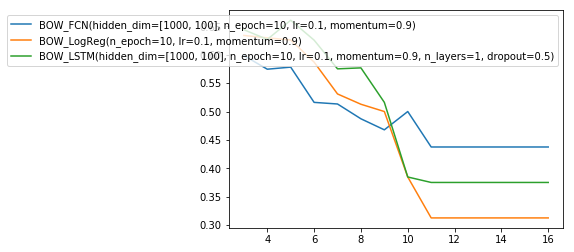

In [157]:
k = 1
pk_vs_len_map = {}

max_len = max(map(len, test_outputs))
for model_name in model_map:
    pks = []
    filtered_logits = test_logits_map[model_name]
    filtered_test_outputs = test_outputs
    
    for filter_len in range(min_len, max_len):
        indices = [i for (i,sequence) in enumerate(filtered_test_outputs) if len(sequence) > filter_len]
        
        filtered_logits = [filtered_logits[i] for i in indices]
        filtered_test_outputs = [filtered_test_outputs[i] for i in indices]
        #print(len(filtered_test_outputs))
        pks.append(precision_at_k(filtered_logits, filtered_test_outputs, k))
    pk_vs_len_map[model_name] = pks
    
max_len = max(map(len, test_outputs))

for model_name, pks in pk_vs_len_map.items():
    plt.plot(np.arange(3,max_len), pks, label=model_name)
plt.legend()